In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Updates
- May 2 | Inital XGBoost Model (Top 89%)
- May 3 | Feature Engineering (Top 67%)
- May 4 | More Feature Engineering (Top 7%)
- May 7 | Basic EDA, added 'ticket' feature (Top 4%)
- ... More EDA to be added

## Features
- Pclass: Class of the Passenger
- Name: Passenger name(title + first name + last name)
- Sex: M/F
- Age: Passenger age
- SibSp: #Spouses or Siblings
- ParCh: #Children or Parents
- Ticket: Ticket identifier
- Fare: USD paid, Numeric
- Cabin: Cabin Number
- Embark: Cock embarked: Southhampton, Queenstown, and Cherbourg

In [2]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import preprocessing

from sklearn import tree

In [3]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing values checking

<AxesSubplot:>

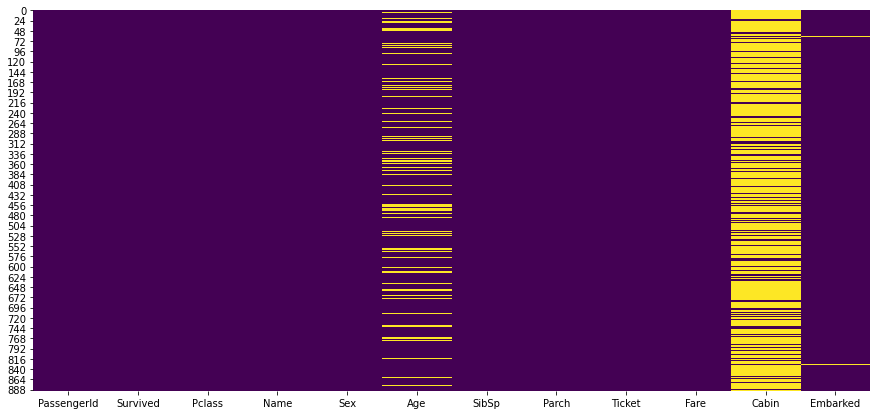

In [5]:
plt.figure(figsize=(15,7))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")

<AxesSubplot:>

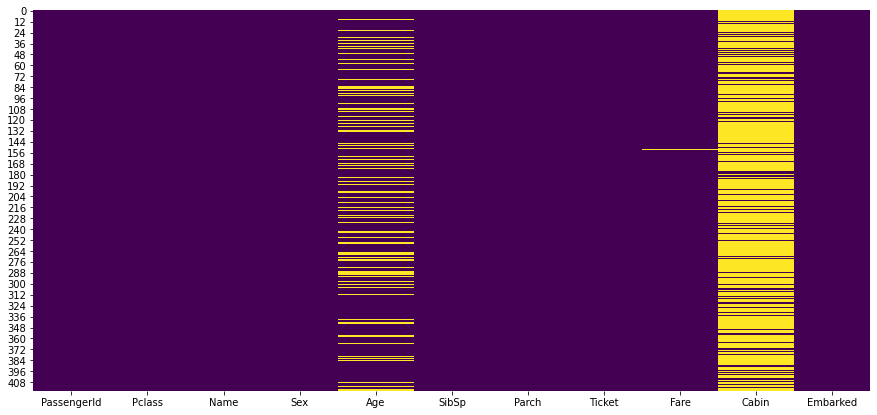

In [6]:
plt.figure(figsize=(15,7))
sns.heatmap(test.isnull(), cbar=False, cmap="viridis")

In [7]:
# dataframe 
df = pd.concat([train, test], axis=0, sort=False)

## Exploratory Data Analysis
- Sex
- Age
- Fare
- Pclass
- Cabin
- Parch, SibSp

### Correlations

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.038354  0.028814 -0.055224  0.008942   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.038354 -0.338481  1.000000 -0.408106  0.060832  0.018322   
Age             0.028814 -0.077221 -0.408106  1.000000 -0.243699 -0.150917   
SibSp          -0.055224 -0.035322  0.060832 -0.243699  1.000000  0.373587   
Parch           0.008942  0.081629  0.018322 -0.150917  0.373587  1.000000   
Fare            0.031428  0.257307 -0.558629  0.178740  0.160238  0.221539   

                 Fare  
PassengerId  0.031428  
Survived     0.257307  
Pclass      -0.558629  
Age          0.178740  
SibSp        0.160238  
Parch        0.221539  
Fare         1.000000  


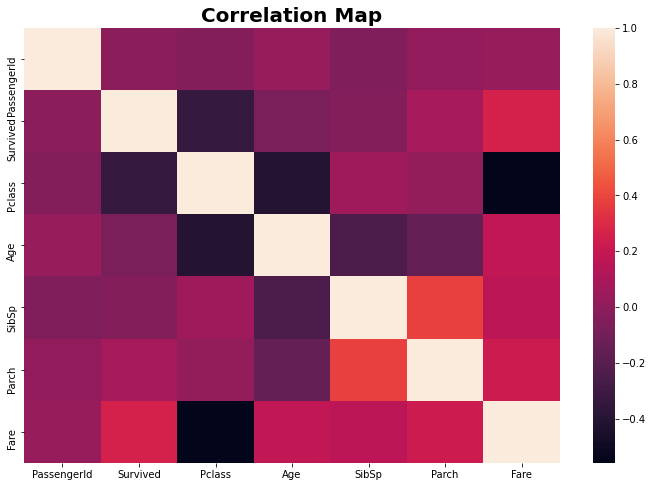

In [8]:
corr_df = df.corr()
print(corr_df)
fig, axs = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_df).set_title("Correlation Map",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

### Survival Factors

In [9]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data=df[columns], kind="reg", plot_kws={'line_kws':{'color':'red'}}, corner=True)

NameError: name 'columns' is not defined

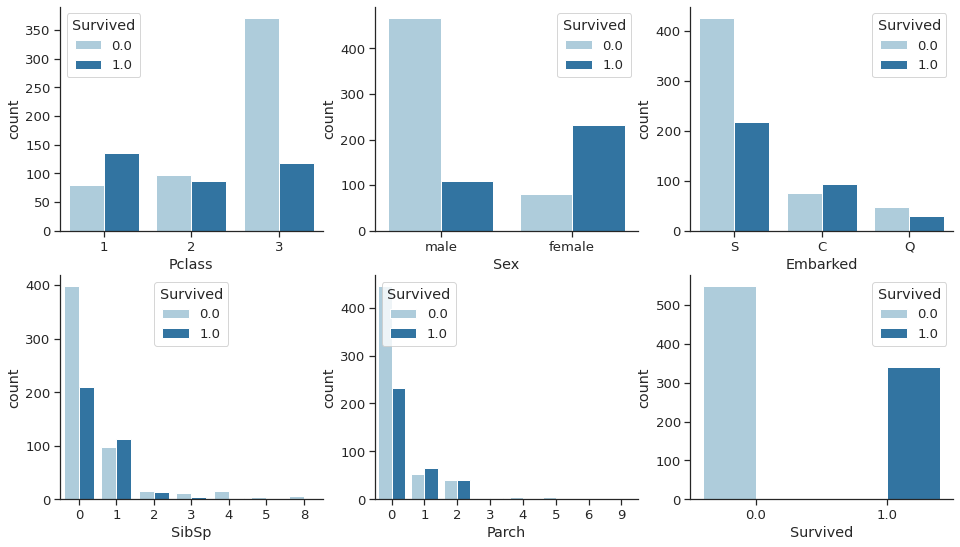

In [10]:
columns = ['Pclass', 'Sex','Embarked','SibSp', 'Parch','Survived']

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=feature, hue='Survived', palette='Paired')
    
sns.despine()

### Sex

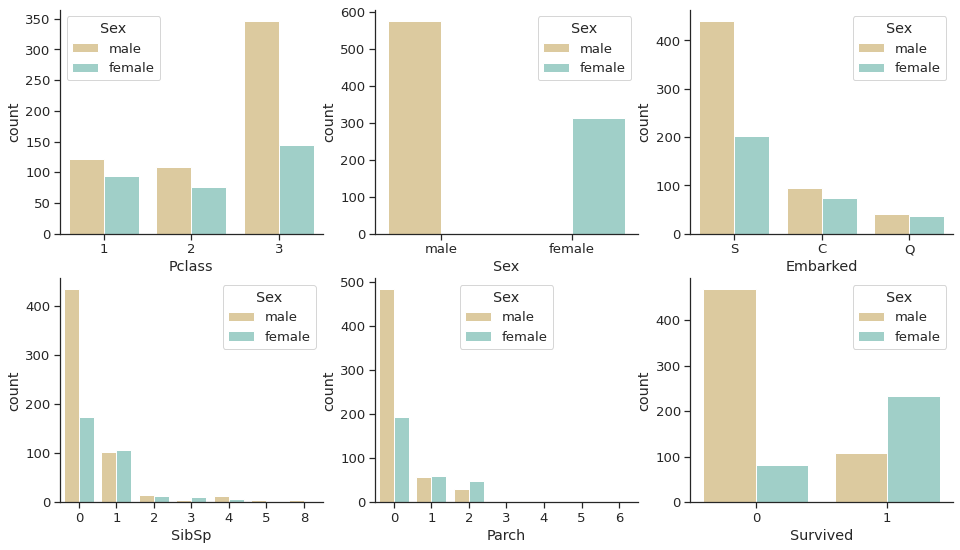

In [11]:
columns = ['Pclass', 'Sex','Embarked','SibSp', 'Parch','Survived']

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=train, x=feature, hue='Sex', palette='BrBG')
    
sns.despine()

### Age
Seem teenage has a higher odds to survive in the disaster

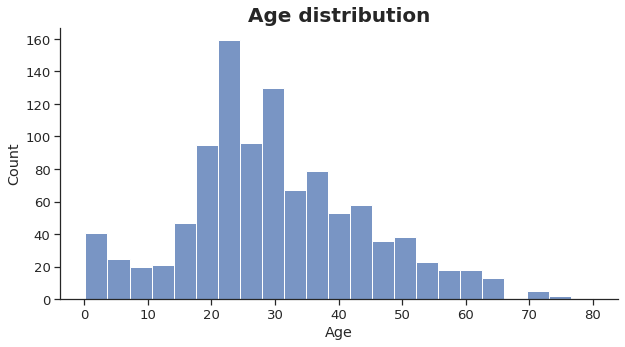

In [12]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Age').set_title("Age distribution",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

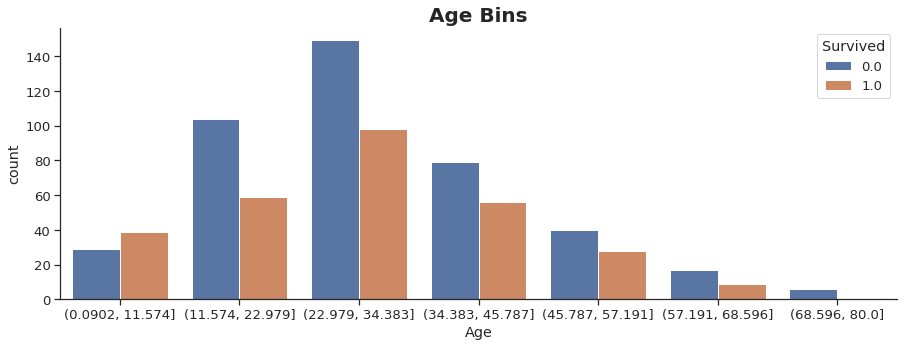

In [13]:
ageBin=pd.cut(df['Age'],7)

fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=ageBin, hue='Survived', data=df)
axs.set_title("Age Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

To handle the missing value of age, we impute it by the average age that people purphrase on a Pclass
- Pclass 1: ~39
- Pclass 2: ~30
- Pclass 3: ~25

In [14]:
df.groupby(by="Pclass", dropna=False).agg('mean')

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,672.492260,0.629630,39.159930,0.436533,0.365325,87.508992
2,671.566787,0.472826,29.506705,0.393502,0.368231,21.179196
3,640.558533,0.242363,24.816367,0.568406,0.400564,13.302889


### Pclass
Majority of first class passengers were allocated at cabin C,E,D,A,B

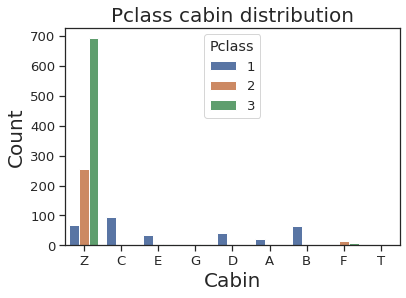

In [15]:
sns.set_style("ticks")
df['Cabin'].fillna('Z',inplace=True)
axs = sns.countplot(x=df['Cabin'].str.get(0), hue="Pclass", data=df)
plt.title('Pclass cabin distribution', fontsize=20)
plt.xlabel('Cabin', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.show()

### Fare
People who survived in the disaster not only bought a first class ticket, but also paid a averagely higher fare

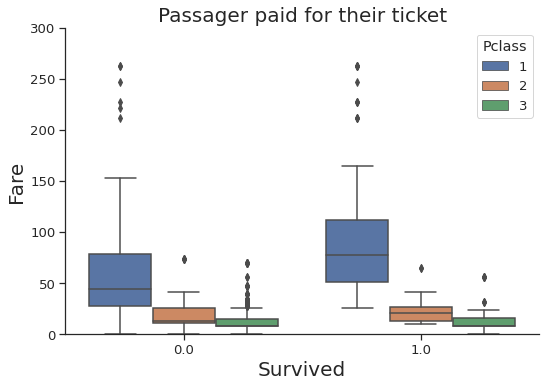

In [16]:
sns.set_style("ticks")
axs = sns.catplot(x="Survived", y="Fare", hue="Pclass", kind="box", data=df,
                 height = 5, aspect = 1.5, legend=False)
axs.set(ylim=(0, 300))
plt.title('Passager paid for their ticket', fontsize=20)
plt.xlabel('Survived', fontsize=20)
plt.ylabel('Fare', fontsize=20)
plt.legend(title='Pclass')
plt.show()

Average Fare Cost for First Class Passagers
- Survived: ~\$95.6
- Died: ~\$64.7

In [17]:
df.groupby(by=["Survived","Pclass"], dropna=True).agg('mean')

PassengerId        Age     SibSp     Parch       Fare
Survived Pclass                                                       
0.0      1        410.300000  43.695312  0.287500  0.300000  64.684008
         2        452.123711  33.544444  0.319588  0.144330  19.412328
         3        453.580645  26.555556  0.672043  0.384409  13.669364
1.0      1        491.772059  35.368197  0.492647  0.389706  95.608029
         2        439.080460  25.901566  0.494253  0.643678  22.055700
         3        394.058824  20.646118  0.436975  0.420168  13.694887

### Fare Bins
Don't just split fare in equally distributed bin, they're long-tail distribution. Preferably doing a log transformation or manually spliting with a unequally sized range could yield a better differentiation between the Fare and Survival Rate

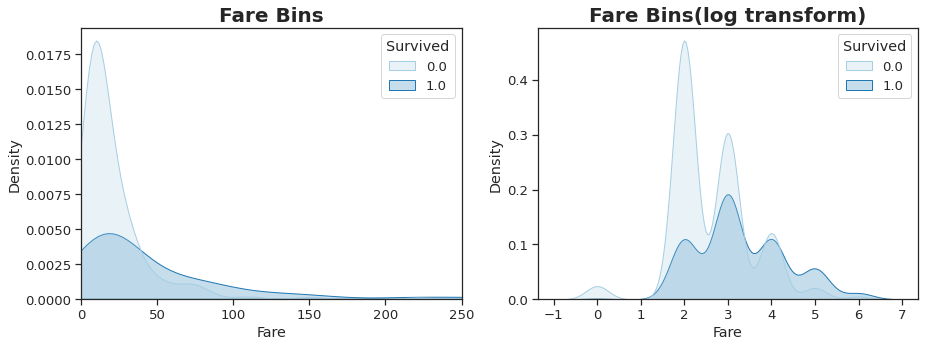

In [18]:
# log transformation
auxfare = np.log(df['Fare']+1).round()

fig, axs = plt.subplots(figsize=(15, 5))
sns.despine()

axs = plt.subplot(1, 2, 1)
sns.kdeplot(x=df['Fare'], hue='Survived', data=df, shade=True, palette='Paired')
axs.set_title("Fare Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
axs.set(xlim=(0, 250))

axs = plt.subplot(1, 2, 2)
sns.kdeplot(x=auxfare, hue='Survived',data=df, shade=True, palette='Paired')
axs.set_title("Fare Bins(log transform)",fontdict= { 'fontsize': 20, 'fontweight':'bold'});

### Cabin Bins
Although most of the Cabin label are missing, we can still surmise that whose Cabin in 'B, C, D, E, F' are more likely to survive.

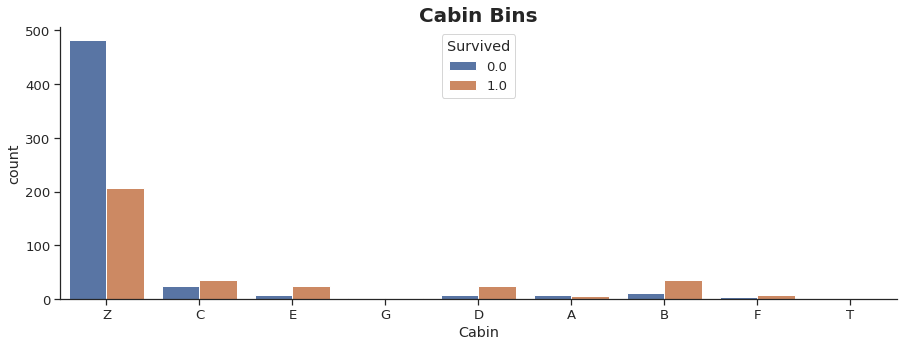

In [19]:
fig, axs = plt.subplots(figsize=(15, 5))
df['Cabin'].fillna('Z',inplace=True)
sns.countplot(x=df['Cabin'].str.get(0), hue='Survived', data=df)
axs.set_title("Cabin Bins",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
sns.despine()

### Parch, SibSp -> is alone
We reduced Parch and SibSp into new feature isAlone. A passager who travel alone has a lower survival rate.

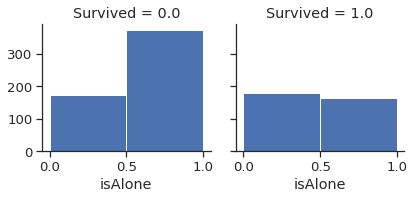

In [20]:
isAlone = lambda cols: 1 if not cols[0] and not cols[1] else 0
df["isAlone"] = df[["Parch", "SibSp"]].apply(isAlone, axis=1)

g = sns.FacetGrid(df, col='Survived', col_wrap=2)
g.map(plt.hist, 'isAlone', bins=2)

## Data preprocessing

### Feature Engeering

In [21]:
df_train = train[['PassengerId','Sex','Pclass','Age','Survived','Embarked','Cabin','Fare','Parch','SibSp','Name','Ticket']]
df_test = test[['PassengerId','Sex','Pclass','Age','Embarked','Cabin','Fare','Parch','SibSp', 'Name','Ticket']]

# Fill n/a with average age by pessagers class
imputeAge = lambda cols: list([39,30,25])[int(cols[1]-1)] if pd.isnull(cols[0]) else cols[0]    
df_train["Age"] = df_train[["Age", "Pclass"]].apply(imputeAge, axis=1)
df_test["Age"] = df_test[["Age", "Pclass"]].apply(imputeAge, axis=1)

def ageBinning(dataset):
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    return dataset

df_train = ageBinning(df_train)
df_test = ageBinning(df_test)
    
def titleBinning(dataset):
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                                 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
    dataset['Title'] = dataset['Title'].fillna(0)
    return dataset

df_train = titleBinning(df_train)
df_test = titleBinning(df_test)

# Identify single onboarding pessagers
isAlone = lambda cols: 1 if not cols[0] and not cols[1] else 0
df_train["isAlone"] = df_train[["Parch", "SibSp"]].apply(isAlone, axis=1)
df_test["isAlone"] = df_test[["Parch", "SibSp"]].apply(isAlone, axis=1)

In [22]:
# Fill n/a with non-existing cabin label 'Z'
df_train['Cabin'].fillna('Z',inplace=True)
df_test['Cabin'].fillna('Z',inplace=True)

# Get Cabin Label
df_train['Cabin'] = df_train['Cabin'].str.get(0)
df_test['Cabin'] = df_test['Cabin'].str.get(0)

# Labeling
le = preprocessing.LabelEncoder()
def labelCol(col):
    le.fit(col)
    return le.transform(col)

df_train['Sex'] = labelCol(df_train['Sex'])
df_test['Sex'] = labelCol(df_test['Sex'])
df_train['Embarked'] = labelCol(df_train['Embarked'])
df_test['Embarked'] = labelCol(df_test['Embarked'])
df_train['Cabin'] = labelCol(df_train['Cabin'])
df_test['Cabin'] = labelCol(df_test['Cabin'])

# Fill n/a
# df_train['Embarked'].fillna(df_train['Embarked'].median()[0],inplace=True)
df_train.Embarked.fillna(df_train.Embarked.median(), inplace = True)

df_test["Fare"].fillna(df_test.groupby(['Pclass', 'Sex'])['Fare'].transform("median"), inplace=True)
# Power law fits better
df_train['Fare'] = np.log(df_train['Fare']+1).round()
df_test['Fare'] = np.log(df_test['Fare']+1).round()

df_train['Age*Class'] = df_train.Age * df_train.Pclass
df_test['Age*Class'] = df_test.Age * df_test.Pclass

df_train['Ticket'] = df_train.Ticket.str.split().apply(lambda x : 0 if x[:][-1] == 'LINE' else x[:][-1])
df_train.Ticket = df_train.Ticket.values.astype('int64')
df_test['Ticket'] = df_test.Ticket.str.split().apply(lambda x : 0 if x[:][-1] == 'LINE' else x[:][-1])
df_test.Ticket = df_test.Ticket.values.astype('int64')

## Training and Fitting

In [23]:
import xgboost as xgb
import sklearn
import scipy

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

target = df_train["Survived"].values
train_features = df_train[["Pclass", "Sex", "Age",'Embarked','Cabin','Fare','Title','isAlone','Age*Class','Ticket']].values
test_features = df_test[["Pclass", "Sex", "Age","Embarked",'Cabin','Fare','Title','isAlone','Age*Class','Ticket']].values

X_train, X_val, y_train, y_val = train_test_split(
    train_features,target , test_size=0.2, random_state=0) 

clf = xgb.XGBClassifier(seed=0, nthread=1)
clf = clf.fit(X_train, 
              y_train, eval_set=[(X_train, y_train),
                                 (X_val, y_val)],
              verbose=False)

y_pred = clf.predict(test_features)
#y_pred = clf.predict(test_features, ntree_limit=clf.booster().best_ntree_limit)
y_pred_probs = clf.predict_proba(test_features)

[05:36:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
y_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [25]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Reference
#### EDA
https://www.kaggle.com/truesight/predicting-titanic-survivor
- complihensive visualization

https://www.kaggle.com/lourenswalters/ii-titanic-exploratory-data-analysis-0-80
#### Feature Engineering
https://www.kaggle.com/startupsci/titanic-data-science-solutions
- verbose feature engineering

https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
- top 3% example

https://www.kaggle.com/javiervallejos/titanic-top-3
#### Hyperparameter Tuning
https://www.kaggle.com/aditiani/survive-from-titanic-using-random-forest-top-17
#### XGBoost Tutorial
https://www.kaggle.com/feralhog/tutorial-xgboost

https://www.slideshare.net/JaroslawSzymczak1/gradient-boosting-in-practice-a-deep-dive-into-xgboost